In [2]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
import matplotlib.pyplot as plt
import aipy
from astropy.io import fits
from scipy.stats import linregress
import os
import glob

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [13]:
def curve_to_fit(lsts, gain, offset):
    '''
    Define curve to fit data to
    offset is Tsys offset from zero = Trxr + g * <Tsky>
    '''
    global interp_values
    return (gain * interp_values + offset)

def gain_rxr_temp(auto_fits, covs, save_npz = True, file_name = 'rxr_temp_w_err'):
    '''
    auto_fits[:, :, :, 0] -> A_0
    auto_fits[:, :, :, 1] -> R_0
    '''
    
    A_0 = auto_fits[:, :, :, 0]
    R_0 = auto_fits[:, :, :, 1]
    
    gains = A_0
    
    rxr_temp = R_0 / A_0 - Tsky_mean[:, None, :]  
    rxr_temp_err = np.sqrt(covs[:,:,:,0,0] * R_0**2 / A_0**4  + 
                           covs[:,:,:,1,1] * 1.0 / A_0**2 - 
                           2 * covs[:,:,:,0,1] * R_0 / A_0**3)
    if save_npz:
        np.savez(file_name, gains=gains, rxr_temp_err=rxr_temp_err, 
                            rxr_temp=rxr_temp, auto_fits=auto_fits,
                            covs=covs)
        
    return gains, rxr_temp, rxr_temp_err

In [14]:
JD = 2458116

Tsky_files = glob.glob('/Users/tyler/Desktop/Research/Tsys/data/*ERA_tsky_fast.npz')

data = np.load('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/2458098/fits.npz'.format(JD))
nrao_feeds = data['nrao_feeds']
HERA_list = data['HERA_list']
freqs = data['freqs']

# Load in data from previous script
autos_file = '/Users/tyler/Desktop/Research/Tsys/data/IDR2_{}_autos.npz'.format(JD)
autos = np.load(autos_file)
data_lsts = autos['lsts']
data_ave = autos['data_ave']

pols = ['X', 'Y']
npol = len(pols)
nant = len(HERA_list)

new_feeds = list(set(HERA_list)-set(nrao_feeds))

In [16]:
# Fit auto data to model
gains = np.zeros((len(Tsky_files), npol, nant, len(freqs)))
rxr_temp = np.zeros((len(Tsky_files), npol, nant, len(freqs)))
rxr_temp_err = np.zeros((len(Tsky_files), npol, nant, len(freqs)))

rerun_fit = True

for si, sf in enumerate(Tsky_files):
    
    data = np.load(sf)
    freqs = data['freqs']  # These are already made to fit the data
    model_lsts = data['lsts']
    model_HERA_Tsky = data['HERA_Tsky']

    # Create interp_func to return Tsky - <Tsky> (ie, deviation from mean)
    interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
    interp_Tsky_array = interp_Tsky(data_lsts[0])
    Tsky_mean = np.mean(interp_Tsky_array, axis=2)
    Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)
    
    auto_fits = np.zeros((npol, nant, len(freqs), 2))  # gain_amp, gain_slope, rxr_amp
    covs = np.zeros((npol, nant, len(freqs), 2, 2))
    
    if os.path.exists('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD)) and not rerun_fit:
        fits_data = np.load('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD))
        gains = fits_data['gains']
        rxr_temp_err = fits_data['rxr_temp_err']
        rxr_temp = fits_data['rxr_temp']

    else:
        for pol in xrange(npol):
            for fi, freq in enumerate(freqs):
                interp_values = Tsky_prime[pol, fi, :]
                for anti, ant in enumerate(HERA_list):
                    out = curve_fit(curve_to_fit, data_lsts[pol], data_ave[pol][ant, :, fi],
                                    bounds=(0, np.inf))
                    auto_fits[pol, anti, fi, :] = out[0]
                    covs[pol, anti, fi, :, :] = out[1]
        g, rt, rt_err = gain_rxr_temp(auto_fits, covs, save_npz=False)
        gains[si, :, :, :] = g
        rxr_temp[si, :, :, :] = rt
        rxr_temp_err[si, :, :, :] = rt_err
        

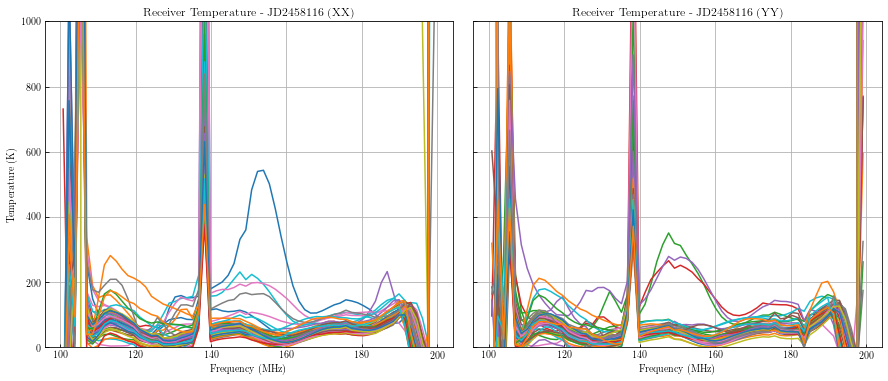

In [17]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, rxr_temp[0, poli, anti, :], label=str(ant))
    axarr[poli].set_ylim([0,1000])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[0].set_xlabel('Frequency (MHz)')
    axarr[1].set_xlabel('Frequency (MHz)')
    axarr[poli].set_title('Receiver Temperature - JD{JD} ({pol})'.format(JD=JD,pol=2*pol))
    axarr[poli].grid()
    
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/receiver_temp_{JD}.png'.format(JD=JD), bbox_inches='tight')

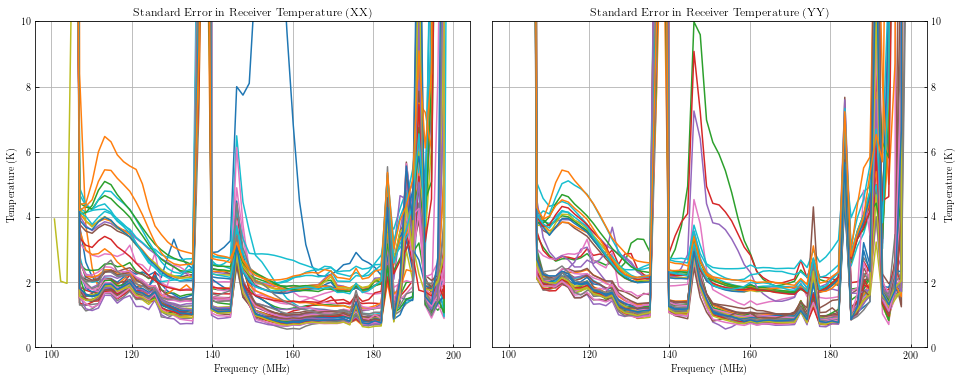

In [18]:
fig, axarr = plt.subplots(1, 2,figsize=(16, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        '''
        if ant in bad_ants[poli]:
            axarr[1].plot(freqs, rxr_temp_err[poli, anti, :], label=str(ant), linestyle='--')
            axarr[0].plot(freqs, rxr_temp[poli, anti, :], label=str(ant), linestyle='--')
        elif ant in [98,66,141]:
            axarr[1].plot(freqs, rxr_temp_err[poli, anti, :], label=str(ant))
            axarr[0].plot(freqs, rxr_temp[poli, anti, :], label=str(ant))
        '''
        axarr[poli].plot(freqs, rxr_temp_err[0, poli, anti, :], label=str(ant))
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,10])
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[poli].set_title('Standard Error in Receiver Temperature ({})'.format(2*pol))
    #plt.show()
axarr[0].grid()
axarr[1].grid()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/rxr_standard_err_{pol}_{JD}.png'.format(pol=2*pol, JD=JD), bbox_inches='tight')

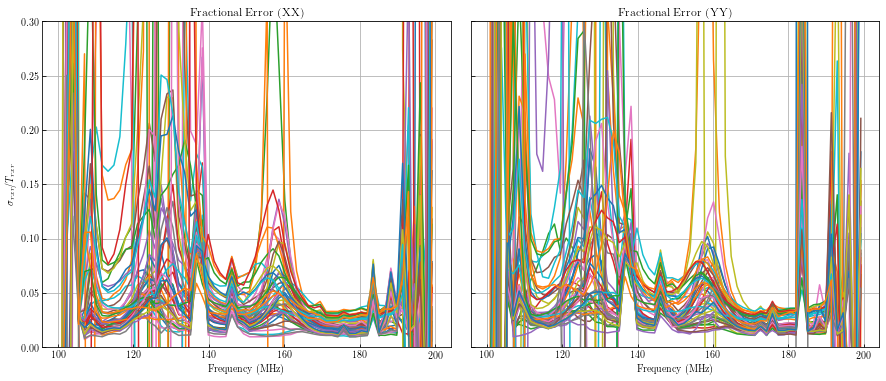

In [19]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, rxr_temp_err[0, poli, anti, :] / rxr_temp[0, poli, anti, :], label=str(ant))
    axarr[poli].set_title('Fractional Error ({})'.format(2*pol))
    axarr[0].set_ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,0.3])
    #axarr[poli].legend()
    axarr[poli].grid()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/rxr_fraction_err_{JD}.png'.format(JD=jd), bbox_inches='tight')


In [29]:
avg_temps = np.zeros((len(Tsky_files), 2, rxr_temp.shape[3]))
avg_err = np.zeros((len(Tsky_files), 2, rxr_temp.shape[3]))

print avg_err.shape

for si in np.arange(len(Tsky_files)):
    for poli, pol in enumerate(pols):
        for i in np.arange(rxr_temp.shape[3]):
            avg_temps[si, poli, i] = np.average(rxr_temp[si, poli,:,i], weights=1.0/rxr_temp_err[si, poli,:,i]**2)
            avg_err[si, poli, i] = np.sqrt(1.0 / np.sum(rxr_temp_err[si, poli,:,i]**(-2)))
            
print avg_err.shape

(1, 2, 64)
(1, 2, 64)


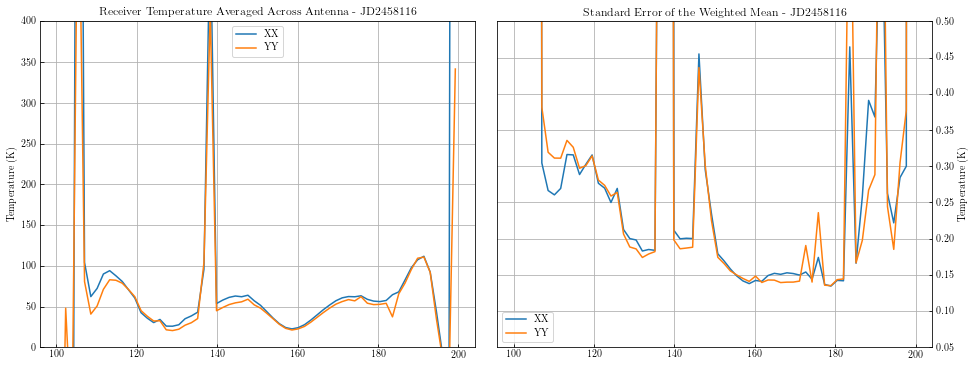

In [32]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

for si, sf in enumerate(Tsky_files):
    for poli, pol in enumerate(pols):    
        axarr[0].plot(freqs, avg_temps[si, poli,:], label=str(2*pol))      
        axarr[0].set_title('Receiver Temperature Averaged Across Antenna - JD{}'.format(JD))
        axarr[0].set_ylim([0,400])
        axarr[0].set_ylabel('Temperature (K)')
        axarr[1].set_ylabel('Temperature (K)')
        axarr[1].plot(freqs, avg_err[si, poli,:], label=str(2*pol)) 
        axarr[1].set_title('Standard Error of the Weighted Mean - JD{}'.format(JD))
        axarr[1].yaxis.tick_right()
        axarr[1].yaxis.set_label_position("right")
        axarr[1].set_ylim([0.05,0.5])
        axarr[0].legend()
        axarr[1].legend()
        axarr[poli].grid()

plt.subplots_adjust(wspace=0.05)
#plt.show()
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/avg_temp_w_err_{JD}.png'.format(JD=jd), bbox_inches='tight')

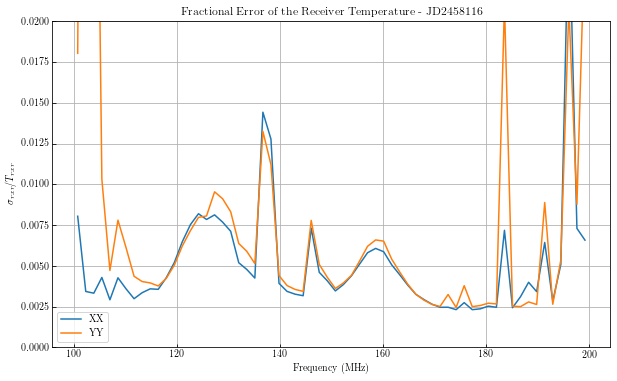

In [37]:
plt.figure(figsize=(10,6))
for si in np.arange(len(Tsky_files)):
    plt.plot(freqs, avg_err[si,0,:] / np.abs(avg_temps[si,0,:]), label='XX')
    plt.plot(freqs, avg_err[si,1,:] / np.abs(avg_temps[si,1,:]), label='YY')
    plt.ylim([0,0.02])
    plt.title('Fractional Error of the Receiver Temperature - JD{}'.format(JD))
    plt.xlabel('Frequency (MHz)')
    plt.ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    plt.legend()
    plt.grid()
#plt.show()
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/avg_fractional_err_{JD}.png'.format(JD=jd), bbox_inches='tight')

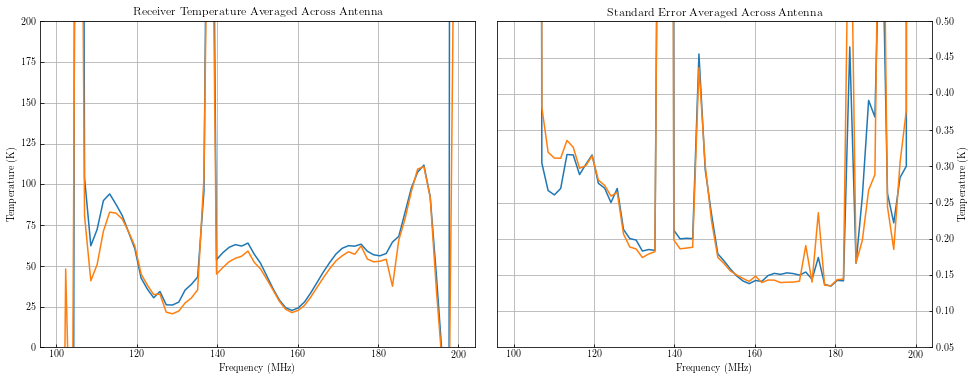

In [40]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

for si, sf in enumerate(Tsky_files):
    for i in np.arange(npol):
        axarr[0].plot(freqs, avg_temps[si,i,:])
        axarr[1].plot(freqs, avg_err[si,i,:])
    axarr[0].set_title('Receiver Temperature Averaged Across Antenna')
    axarr[0].set_ylim([0,200])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[1].set_ylabel('Temperature (K)')
    axarr[0].set_xlabel('Frequency (MHz)')
    axarr[1].set_xlabel('Frequency (MHz)')
    axarr[1].set_title('Standard Error Averaged Across Antenna')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[1].set_ylim([0.05,0.5])
    #axarr[0].legend()
    #axarr[1].legend()
    axarr[0].grid()
    axarr[1].grid()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('averaged_receiver_temp.png', bbox_inches='tight')

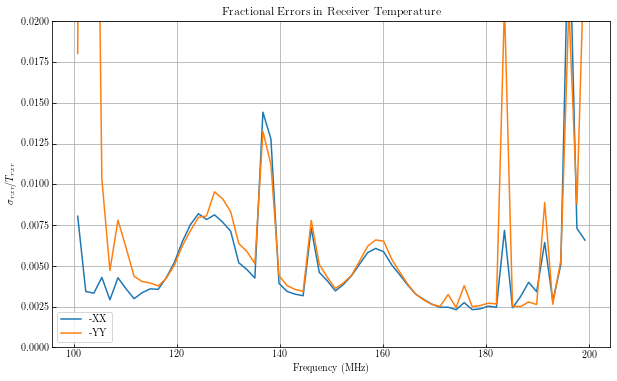

In [44]:
plt.figure(figsize=(10,6))

for si, sf in enumerate(Tsky_files):
    for i in np.arange(npol):
        plt.plot(freqs, np.abs(avg_err[si, i, :]/ avg_temps[si, i, :]) , label= '-' + 2*pols[i])

plt.grid()
plt.legend()
plt.ylim([0,0.02])
plt.xlabel('Frequency (MHz)')
plt.ylabel(r'$\sigma_{rxr} / T_{rxr}$')
plt.title('Fractional Errors in Receiver Temperature')
plt.show()
#plt.savefig('fractional_errors.png', bbox_inches='tight')